In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.stats import linregress
import os
from lmfit import Model

In [3]:
df = pd.read_csv("./data/raw_data/GM.txt",delim_whitespace=True)
print(df.head)

<bound method NDFrame.head of         imagenum  twotheta  twotheta_cuka  dspacing   qvalue  intensity  \
0              0      5.00        6.21396  14.21205  0.44210     131.01   
1              0      5.02        6.23883  14.15547  0.44387     138.15   
2              0      5.04        6.26369  14.09933  0.44564     145.25   
3              0      5.06        6.28856  14.04364  0.44740     107.40   
4              0      5.08        6.31342  13.98838  0.44917      71.75   
...          ...       ...            ...       ...      ...        ...   
109995        87     29.90       37.39301   2.40302  2.61471     100.45   
109996        87     29.92       37.41836   2.40145  2.61641      99.31   
109997        87     29.94       37.44371   2.39988  2.61812     122.83   
109998        87     29.96       37.46906   2.39832  2.61983     136.38   
109999        87     29.98       37.49441   2.39675  2.62154     157.79   

        frame_number   izero        date      time  
0               

In [53]:
# Define the Pseudo-Voigt profile function with normalization
def pseudovoigt(x, center, amplitude, sigma, eta=0.7):
    gaussian = np.exp(-(x - center)**2 / (2 * sigma**2))
    lorentzian = 1 / (1 + ((x - center) / sigma)**2)
    return amplitude * (eta * lorentzian + (1 - eta) * gaussian)

# Calculate FWHM of the Pseudo-Voigt profile
def calculate_fwhm(sigma, eta):
    fwhm_gaussian = 2.35482 * sigma  # 2 * sqrt(2 * log(2))
    fwhm_lorentzian = 2 * sigma
    return eta * fwhm_lorentzian + (1 - eta) * fwhm_gaussian

# Fit the Pseudo-Voigt model and return parameters and FWHM
def fit_pseudovoigt(x, y, eta=0.7):
    def fit_function(x, center, amplitude, sigma):
        return pseudovoigt(x, center, amplitude, sigma, eta)
    
    try:
        initial_sigma = (x.max() - x.min()) / 4
        popt, pcov = curve_fit(fit_function, x, y, p0=[x.mean(), y.max(), initial_sigma], maxfev=5000)
        sigma = popt[2]  # Optimized sigma
        fwhm = calculate_fwhm(sigma, eta)
        return popt, pcov, fwhm
    except Exception as e:
        print(f"Fit error: {e}")
        return [x.mean(), y.max(), initial_sigma], None, calculate_fwhm(initial_sigma, eta)

# Process a single file to fit Pseudo-Voigt profiles and calculate areas
def process_file(csv_path, output_csv_path, eta=0.7, q_min=2.0, q_max=2.1):
    df = pd.read_csv(csv_path)
    
    # Check if required columns are present
    required_columns = {'frame_number', 'qvalue', 'intensity_izero_normalized', 'duration_s'}
    if not required_columns.issubset(df.columns):
        missing_cols = required_columns - set(df.columns)
        print(f"Missing required columns: {missing_cols}")
        return
    
    results = []
    grouped = df.groupby('frame_number')
    
    for frame, group in grouped:
        # Filter for q-value range
        group_filtered = group[(group['qvalue'] >= q_min) & (group['qvalue'] <= q_max)]
        
        if group_filtered.empty:
            print(f"No data in the specified q-value range for frame {frame}.")
            continue
        
        q_values = group_filtered['qvalue']
        intensities = group_filtered['intensity_izero_normalized']
        duration_s = group_filtered['duration_s'].iloc[0]  # Assuming duration is constant within a frame
        
        popt, _, fwhm = fit_pseudovoigt(q_values, intensities, eta)
        
        # Calculate area using numerical integration
        def integral_function(x):
            return pseudovoigt(x, *popt, eta)
        
        area, _ = quad(integral_function, q_min, q_max)
        
        results.append({
            'frame_number': frame,
            'duration_s': duration_s,
            'FWHM': fwhm,
            'sigma': popt[2],
            'pseudovoigt_area': area,
            'pseudovoigt_amplitude': popt[1]
        })
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

# Process each file
files = [
    './data/GC.csv',
    './data/GM.csv',
    './data/GEC.csv',
    './data/MF.csv'
]

for fname in files:
    csv_path = fname
    base, ext = os.path.splitext(fname)
    output_csv_path = base + 'PbI2_pv' + ext  # Add _pv before the file extension
    if os.path.exists(csv_path):
        process_file(csv_path, output_csv_path, q_min=1.8, q_max=1.9)
    else:
        print(f"File {csv_path} does not exist.")

Results saved to ./data/GCPbI2_pv.csv
Results saved to ./data/GMPbI2_pv.csv
Results saved to ./data/GECPbI2_pv.csv
Results saved to ./data/MFPbI2_pv.csv


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


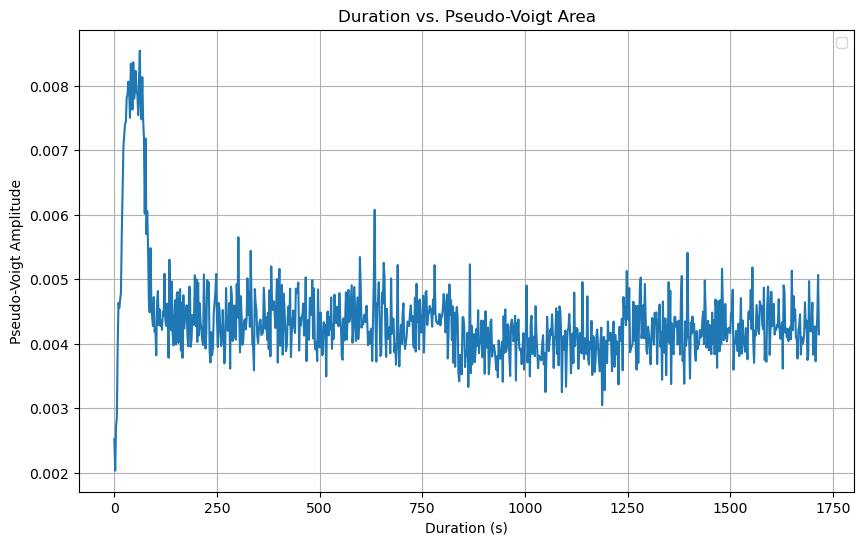

In [54]:
# Load the CSV file
file_path = 'data/PbI2_GC_pv.csv'  # Replace with the path to your CSV file
data = pd.read_csv(file_path)

# Plot duration_s against pseudo_voigt_area
plt.figure(figsize=(10, 6))
plt.plot(data['duration_s'], data['pseudovoigt_area'])

# Adding title and labels
plt.title('Duration vs. Pseudo-Voigt Area')
plt.xlabel('Duration (s)')
plt.ylabel('Pseudo-Voigt Amplitude')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


### Original Data vs Smoothed data

First 5 values of the original data:
   duration_s  pseudovoigt_area
0           0          0.004821
1           2          0.004146
2           4          0.003639
3           6          0.004458
4           8          0.003214

First 5 values of the smoothed data:
   duration_s  smoothed_pseudovoigt_area
0           0                   0.004821
1           2                   0.004483
2           4                   0.004202
3           6                   0.004266
4           8                   0.004056


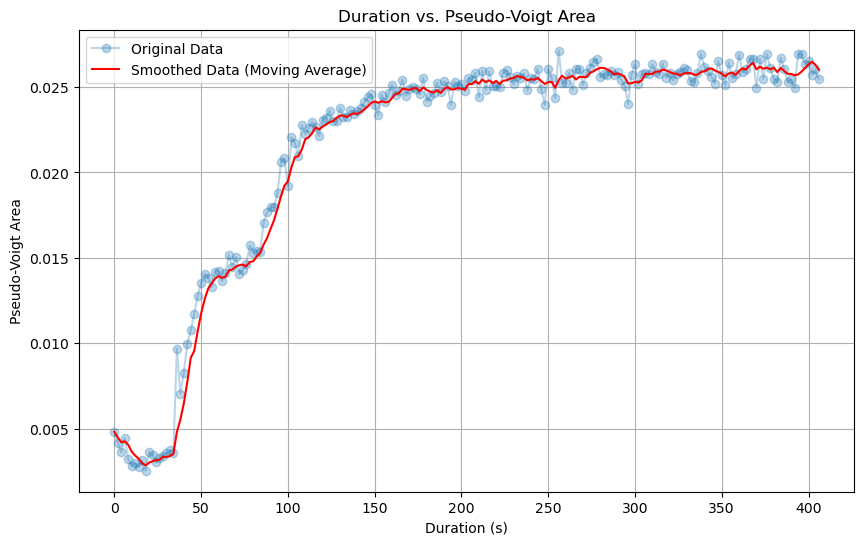

In [5]:

file_path = 'data/100_MF_pv.csv'  # Replace with the path to your CSV file
data = pd.read_csv(file_path)

# Check if the necessary columns are present in the data
if 'duration_s' not in data.columns or 'pseudovoigt_area' not in data.columns:
    raise ValueError("The CSV file must contain 'duration_s' and 'pseudovoigt_area' columns.")

# Moving average function with min_periods=1 to include the first 5 values
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

# Apply moving average with a window size of 5
window_size = 5
smoothed_data = moving_average(data['pseudovoigt_area'], window_size)

# Display the first 5 values of the original and smoothed data
print("First 5 values of the original data:")
print(data[['duration_s', 'pseudovoigt_area']].head())

print("\nFirst 5 values of the smoothed data:")
print(pd.DataFrame({'duration_s': data['duration_s'], 'smoothed_pseudovoigt_area': smoothed_data}).head())

# Plot duration_s against smoothed pseudovoigt_area
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(data['duration_s'], data['pseudovoigt_area'], 'o-', alpha=0.3, label='Original Data')

# Plot smoothed data
plt.plot(data['duration_s'], smoothed_data, 'r-', label='Smoothed Data (Moving Average)')

# Adding title and labels
plt.title('Duration vs. Pseudo-Voigt Area')
plt.xlabel('Duration (s)')
plt.ylabel('Pseudo-Voigt Area')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


### Pseudo Voigt Area versus Time

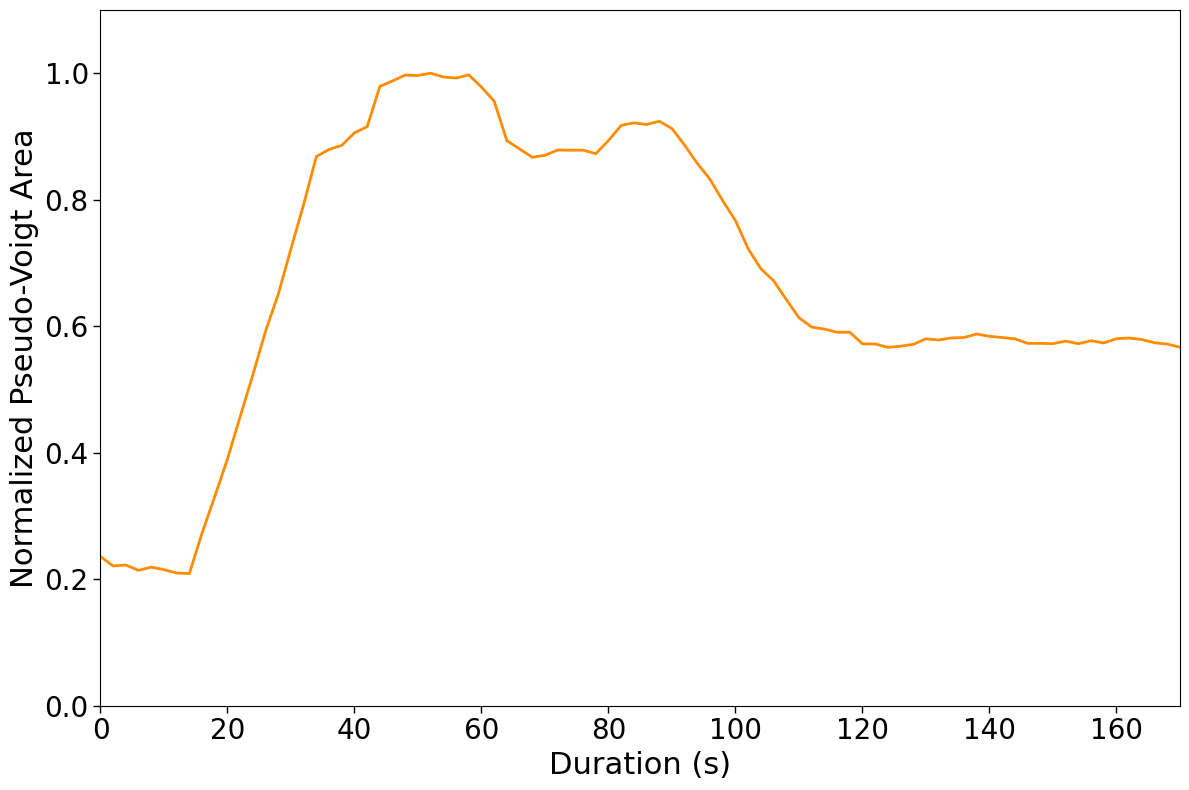

First 5 values of the normalized smoothed data:
   duration_s  normalized_smoothed_pseudovoigt_area
0           0                              0.235763
1           2                              0.220874
2           4                              0.222353
3           6                              0.213918
4           8                              0.219023


In [59]:
# Load the CSV file
file_path = 'data/PbI2_GM_pv.csv'  # Replace with the path to your CSV file
data = pd.read_csv(file_path)

# Check if the necessary columns are present in the data
if 'duration_s' not in data.columns or 'pseudovoigt_area' not in data.columns:
    raise ValueError("The CSV file must contain 'duration_s' and 'pseudovoigt_area' columns.")

# Moving average function with min_periods=1 to include the first 5 values
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

# Apply moving average with a window size of 10
window_size = 10
smoothed_data = moving_average(data['pseudovoigt_area'], window_size)

# Set x-axis range
x_min, x_max = 0, 170

# Find the maximum area within the x-limit range
mask = (data['duration_s'] >= x_min) & (data['duration_s'] <= x_max)
max_area = smoothed_data[mask].max()

# Normalize the smoothed data
normalized_data = smoothed_data / max_area

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)  # Default figure size and dpi

# Plot normalized smoothed data
ax.plot(data['duration_s'], normalized_data, color='darkorange', linewidth=2.0)  # Line thickness 2

# Adding labels with larger fonts
ax.set_xlabel('Duration (s)', fontsize=22)
ax.set_ylabel('Normalized Pseudo-Voigt Area', fontsize=22)

# Set x-axis range
ax.set_xlim(x_min, x_max)

# Set y-axis range from 0 to 1.1 (normalized)
ax.set_ylim(0, 1.1)

# Ensure axes are visible on all sides
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Adjust tick parameters with larger fonts
ax.tick_params(axis='both', which='major', labelsize=20, width=1.0, length=5)
ax.tick_params(axis='both', which='minor', labelsize=20, width=1.0, length=5)

# Show plot
plt.tight_layout()

plt.show()

# Display the first 5 values of the normalized smoothed data
print("First 5 values of the normalized smoothed data:")
print(pd.DataFrame({'duration_s': data['duration_s'], 'normalized_smoothed_pseudovoigt_area': normalized_data}).head())


## PseudoVoigt Area Comparison

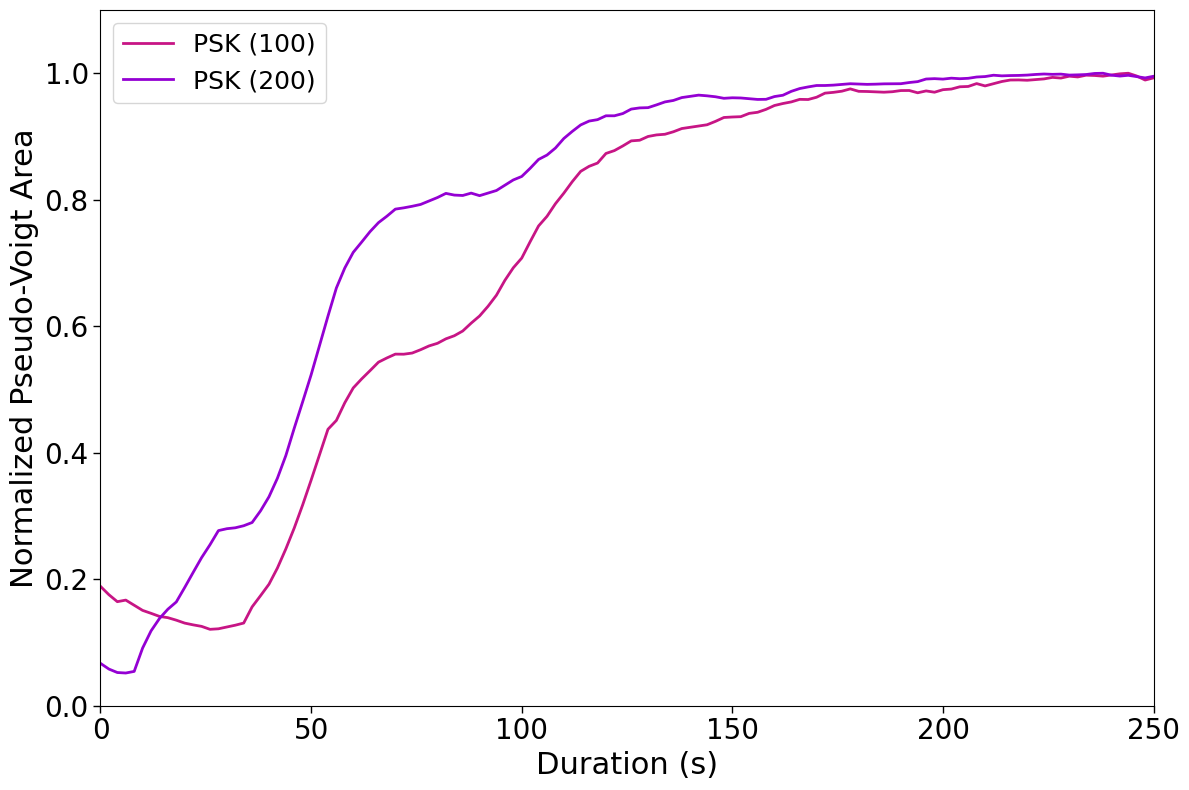

In [52]:
# Load the CSV files
file_path_1 = 'data/100_MF_pv.csv'  # Replace with the path to your first CSV file
file_path_2 = 'data/200_MF_pv.csv'  # Replace with the path to your second CSV file

data_1 = pd.read_csv(file_path_1)
data_2 = pd.read_csv(file_path_2)

# Check if the necessary columns are present in the data
for data in [data_1, data_2]:
    if 'duration_s' not in data.columns or 'pseudovoigt_area' not in data.columns:
        raise ValueError("The CSV files must contain 'duration_s' and 'pseudovoigt_area' columns.")

# Moving average function with min_periods=1 to include the first 5 values
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

# Apply moving average with a window size of 10
window_size = 10
smoothed_data_1 = moving_average(data_1['pseudovoigt_area'], window_size)
smoothed_data_2 = moving_average(data_2['pseudovoigt_area'], window_size)

# Set x-axis range
x_min, x_max = 0, 250

# Find the maximum area within the x-limit range for both datasets
mask_1 = (data_1['duration_s'] >= x_min) & (data_1['duration_s'] <= x_max)
mask_2 = (data_2['duration_s'] >= x_min) & (data_2['duration_s'] <= x_max)

max_area_1 = smoothed_data_1[mask_1].max()
max_area_2 = smoothed_data_2[mask_2].max()

# Normalize the smoothed data
normalized_data_1 = smoothed_data_1 / max_area_1
normalized_data_2 = smoothed_data_2 / max_area_2

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)  # Default figure size and dpi

# Plot normalized smoothed data
ax.plot(data_1['duration_s'], normalized_data_1, color='mediumvioletred', linewidth=2.0, label='PSK (100)')
ax.plot(data_2['duration_s'], normalized_data_2, color='darkviolet', linewidth=2.0, label='PSK (200)')

# Adding labels with larger fonts
ax.set_xlabel('Duration (s)', fontsize=22)
ax.set_ylabel('Normalized Pseudo-Voigt Area', fontsize=22)

# Set x-axis range
ax.set_xlim(x_min, x_max)

# Set y-axis range from 0 to 1.1 (normalized)
ax.set_ylim(0, 1.1)

# Ensure axes are visible on all sides
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Adjust tick parameters with larger fonts
ax.tick_params(axis='both', which='major', labelsize=20, width=1.0, length=5)
ax.tick_params(axis='both', which='minor', labelsize=20, width=1.0, length=5)

# Add legend
ax.legend(fontsize=18)

# Show plot
plt.tight_layout()

plt.show()


### Avrami 

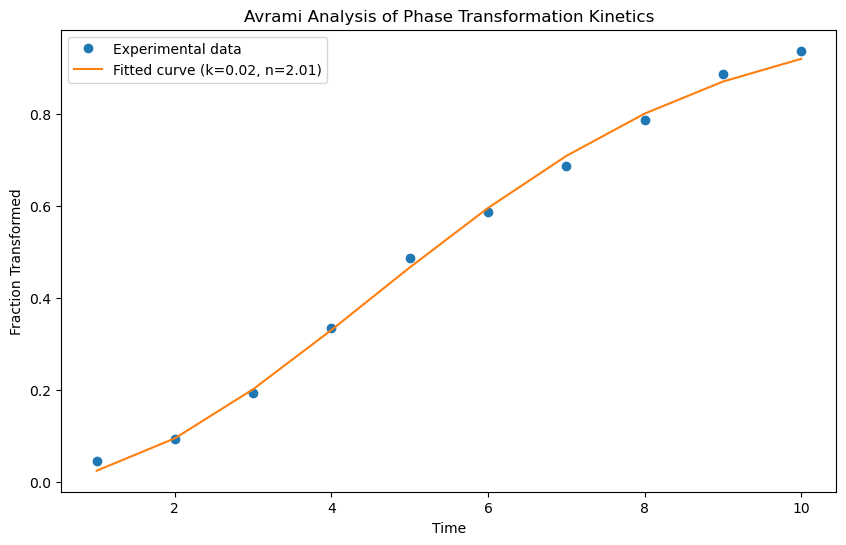

Fitted parameters: k = 0.02, n = 2.01


In [38]:
# Hypothetical XRD data for different peaks over time
data = {
    'time': np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
    '100_peak_area': np.array([0.05, 0.10, 0.20, 0.35, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95]),
    '200_peak_area': np.array([0.04, 0.08, 0.18, 0.32, 0.48, 0.58, 0.68, 0.78, 0.88, 0.93]),
    '111_peak_area': np.array([0.03, 0.07, 0.17, 0.30, 0.45, 0.55, 0.65, 0.75, 0.85, 0.90]),
    '211_peak_area': np.array([0.06, 0.12, 0.22, 0.37, 0.52, 0.62, 0.72, 0.82, 0.92, 0.97])
}

# Convert data to DataFrame for easier handling
df = pd.DataFrame(data)

# Average the peak areas to get a representative fraction transformed
df['fraction_transformed'] = df[['100_peak_area', '200_peak_area', '111_peak_area', '211_peak_area']].mean(axis=1)

# the Avrami equation
def avrami_equation(t, k, n):
    return 1 - np.exp(-k * t**n)

# Fit the Avrami equation to the averaged fraction transformed data
popt, pcov = curve_fit(avrami_equation, df['time'], df['fraction_transformed'])
k, n = popt

# Plot the experimental data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['fraction_transformed'], 'o', label='Experimental data')
plt.plot(df['time'], avrami_equation(df['time'], *popt), '-', label=f'Fitted curve (k={k:.2f}, n={n:.2f})')
plt.xlabel('Time')
plt.ylabel('Fraction Transformed')
plt.title('Avrami Analysis of Phase Transformation Kinetics')
plt.legend()
plt.show()

print(f"Fitted parameters: k = {k:.2f}, n = {n:.2f}")


## n

The avrami exponent, n, determined from t he slope of the plot of the ln(-ln(1-X(t))) versus ln(t).

The value of n provides insights into the nature of the nucleation and growth processes (e.g., whether nucleation is instantaneous or continuous, and whether growth is one-dimensional, two-dimensional, or three-dimensional).

If n is close to 1, nucelation might be spontaneous, if n>1, nucleation might be continuous. 

n=1 -> one dimensional growth (needle like crystal)
n=2 -> might indicate two-dimensional growth (needle-like crsytal)
n=3 -> might indicate 3D growth (spherical growth)

## UNSUCCESFULL - Fitting using the Avrami Equation 

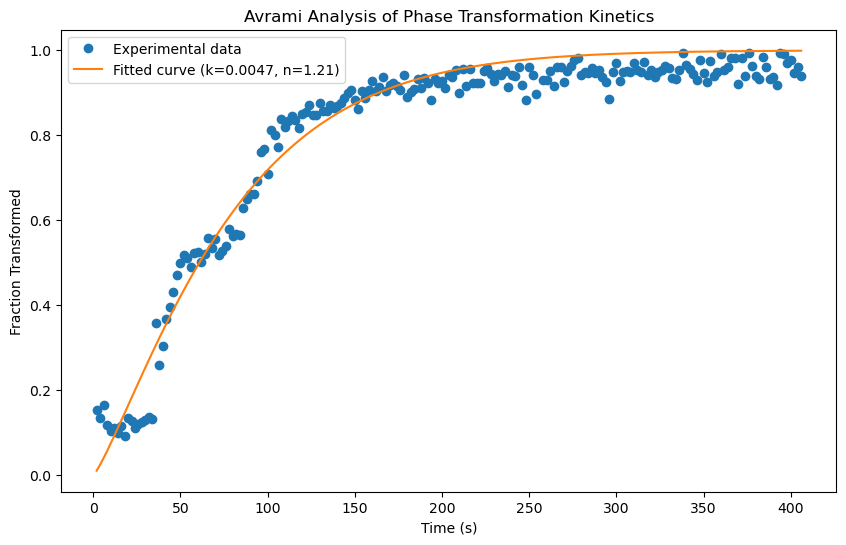

Fitted parameters: k = 0.0047, n = 1.21


In [25]:
# Load the data
data = pd.read_csv('data/100_MF_pv.csv')
data = data[data['duration_s'] > 0]

# Calculate the fraction transformed
max_area_peak_100 = data['pseudovoigt_area'].max()
data['alpha'] = data['pseudovoigt_area'] / max_area_peak_100

# Filter out invalid alpha values (alpha should be between 0 and 1)
valid_data = data[(data['alpha'] > 0) & (data['alpha'] < 1)]

# Define the Avrami equation
def avrami_equation(t, k, n):
    return 1 - np.exp(-k * t**n)

# Fit the Avrami equation to the valid data
# Provide initial guess for k and n
initial_guess = [0.001, 1.0]  # Adjust these values based on your expectations
popt, pcov = curve_fit(avrami_equation, valid_data['duration_s'], valid_data['alpha'], p0=initial_guess)

k, n = popt

# Plot the experimental data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(valid_data['duration_s'], valid_data['alpha'], 'o', label='Experimental data')
plt.plot(valid_data['duration_s'], avrami_equation(valid_data['duration_s'], *popt), '-', label=f'Fitted curve (k={k:.4f}, n={n:.2f})')
plt.xlabel('Time (s)')
plt.ylabel('Fraction Transformed')
plt.title('Avrami Analysis of Phase Transformation Kinetics')
plt.legend()
plt.show()

print(f"Fitted parameters: k = {k:.4f}, n = {n:.2f}")

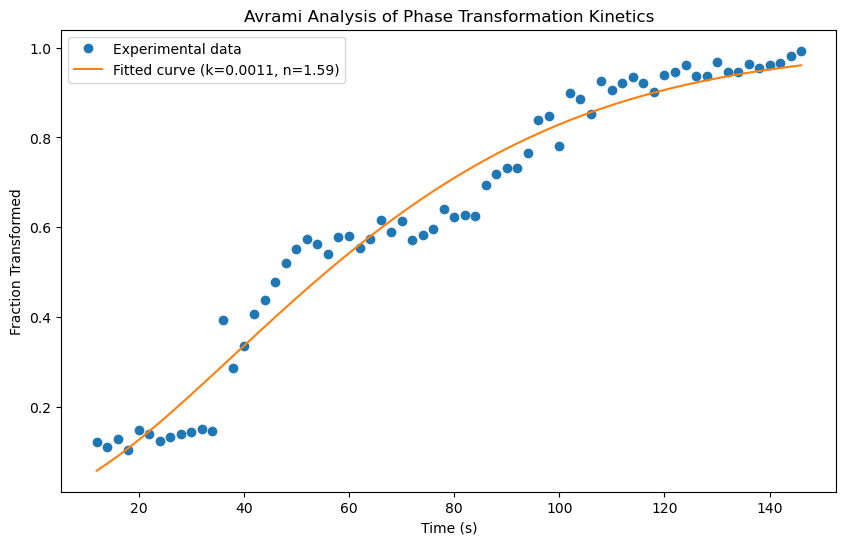

Fitted parameters: k = 0.0011, n = 1.59


In [21]:
# Load the data
data = pd.read_csv('data/100_MF_pv.csv')
data = data[data['duration_s'] > 10]
data = data[data['duration_s'] < 150]
# Calculate the fraction transformed
max_area_peak_100 = data['pseudovoigt_area'].max()
data['alpha'] = data['pseudovoigt_area'] / max_area_peak_100

# Filter out invalid alpha values (alpha should be between 0 and 1)
valid_data = data[(data['alpha'] > 0) & (data['alpha'] < 1)]

# Define the Avrami equation
def avrami_equation(t, k, n):
    return 1 - np.exp(-k * t**n)

# Fit the Avrami equation to the valid data
# Provide initial guess for k and n
initial_guess = [0.001, 1.0]  # Adjust these values based on your expectations

# Set bounds for the parameters
bounds = (0, [np.inf, np.inf])  # k and n must be non-negative

# Perform the curve fitting with bounds
popt, pcov = curve_fit(avrami_equation, valid_data['duration_s'], valid_data['alpha'], p0=initial_guess, bounds=bounds)

k, n = popt

# Plot the experimental data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(valid_data['duration_s'], valid_data['alpha'], 'o', label='Experimental data')
plt.plot(valid_data['duration_s'], avrami_equation(valid_data['duration_s'], *popt), '-', label=f'Fitted curve (k={k:.4f}, n={n:.2f})')
plt.xlabel('Time (s)')
plt.ylabel('Fraction Transformed')
plt.title('Avrami Analysis of Phase Transformation Kinetics')
plt.legend()
plt.show()

print(f"Fitted parameters: k = {k:.4f}, n = {n:.2f}")


### Double Sigmoid Fit

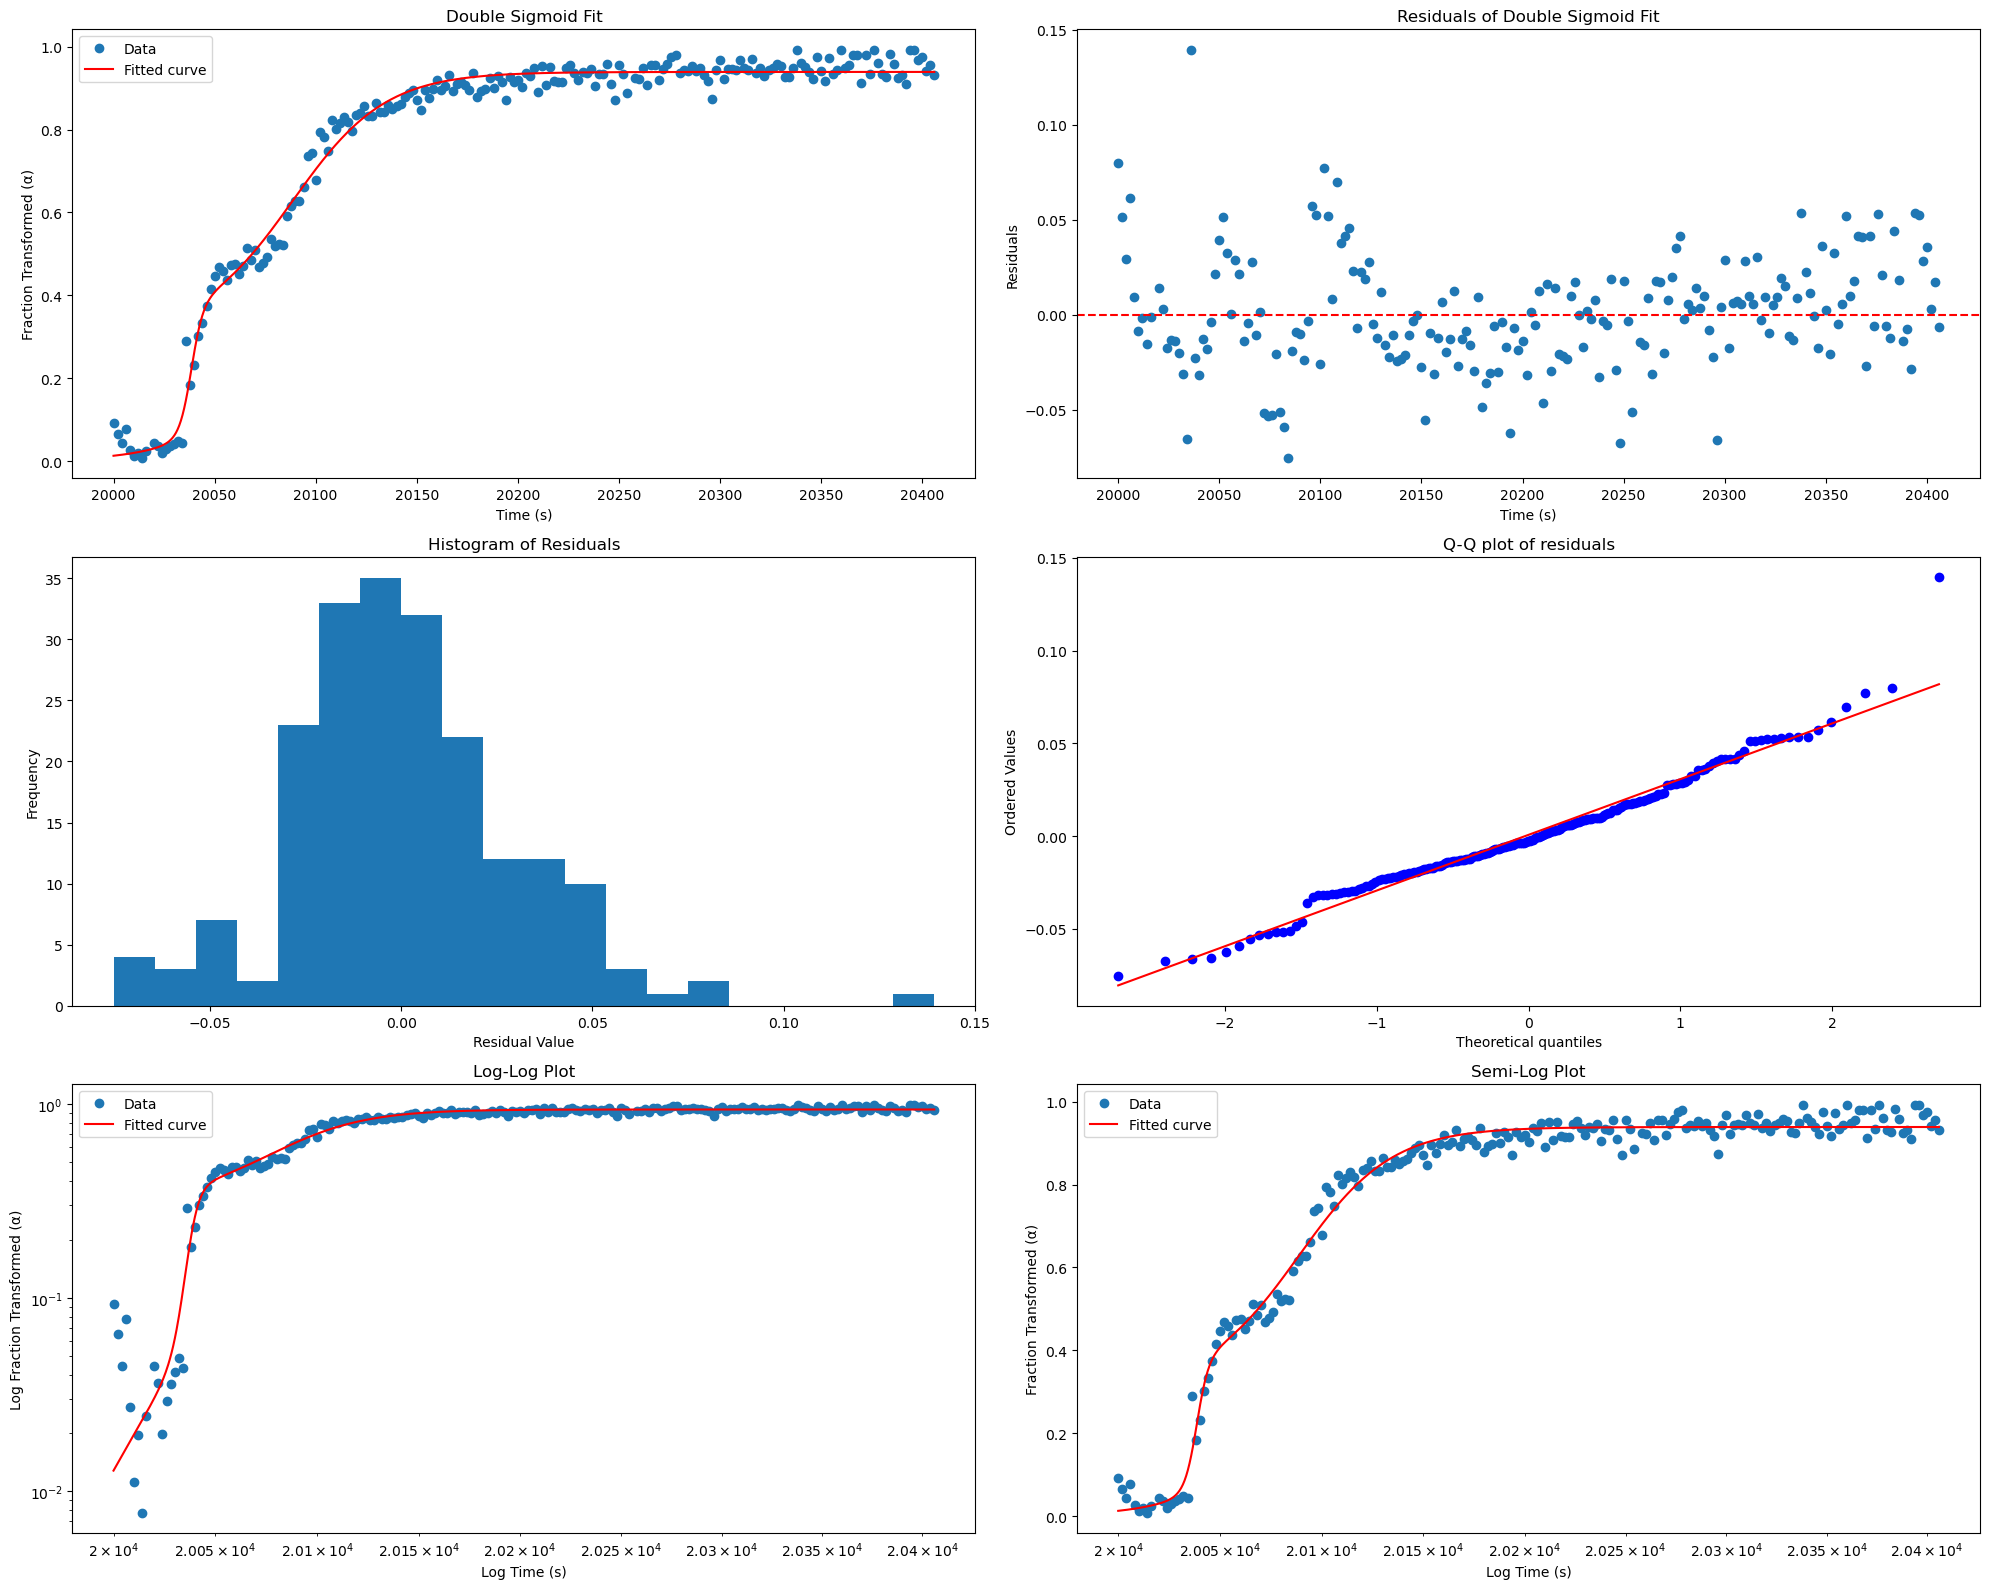

Fitted parameters:
a1 = 0.623304 ± 0.029291
b1 = 0.043654 ± 0.002289
c1 = 20088.518221 ± 2.608879
a2 = 0.315682 ± 0.028853
b2 = 0.341955 ± 0.079900
c2 = 20038.498983 ± 0.638760

Number of valid data points: 202
Time range: 20000.00 to 20406.00
Alpha range: 0.01 to 0.99


In [23]:
# Load the data
data = pd.read_csv('data/100_MF_pv.csv')

# Create a new time column (2 seconds per frame)
data['time_s'] = data['frame_number'] * 2

# Calculate the fraction transformed starting from the minimum area
min_area = data['pseudovoigt_area'].min()
max_area = data['pseudovoigt_area'].max()
data['alpha'] = (data['pseudovoigt_area'] - min_area) / (max_area - min_area)

# Filter out invalid alpha values (alpha should be between 0 and 1)
valid_data = data[(data['alpha'] > 0) & (data['alpha'] < 1)]

# Define the double sigmoid function
def double_sigmoid(t, a1, b1, c1, a2, b2, c2):
    return a1 / (1 + np.exp(-b1 * (t - c1))) + a2 / (1 + np.exp(-b2 * (t - c2)))

# Perform non-linear curve fitting
initial_guess = [0.5, 0.1, np.median(valid_data['time_s']), 
                 0.5, 0.1, np.median(valid_data['time_s'])]
bounds = ([0, 0, valid_data['time_s'].min(), 0, 0, valid_data['time_s'].min()],
          [1, 1, valid_data['time_s'].max(), 1, 1, valid_data['time_s'].max()])

try:
    popt, pcov = curve_fit(double_sigmoid, valid_data['time_s'], valid_data['alpha'], 
                           p0=initial_guess, bounds=bounds, maxfev=10000)
    
    # Calculate standard errors
    perr = np.sqrt(np.diag(pcov))
    
    # Generate fitted curve
    t_fit = np.linspace(valid_data['time_s'].min(), valid_data['time_s'].max(), 1000)
    alpha_fit = double_sigmoid(t_fit, *popt)
    
    # Plot results
    plt.figure(figsize=(20, 16))
    
    # Raw data and fitted curve
    plt.subplot(3, 2, 1)
    plt.plot(valid_data['time_s'], valid_data['alpha'], 'o', label='Data')
    plt.plot(t_fit, alpha_fit, 'r-', label='Fitted curve')
    plt.xlabel('Time (s)')
    plt.ylabel('Fraction Transformed (α)')
    plt.title('Double Sigmoid Fit')
    plt.legend()
    
    # Residuals
    plt.subplot(3, 2, 2)
    residuals = valid_data['alpha'] - double_sigmoid(valid_data['time_s'], *popt)
    plt.plot(valid_data['time_s'], residuals, 'o')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Residuals')
    plt.title('Residuals of Double Sigmoid Fit')
    
    # Histogram of residuals
    plt.subplot(3, 2, 3)
    plt.hist(residuals, bins=20)
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Residuals')
    
    # Q-Q plot of residuals
    plt.subplot(3, 2, 4)
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q plot of residuals")
    
    # Log-log plot
    plt.subplot(3, 2, 5)
    plt.loglog(valid_data['time_s'], valid_data['alpha'], 'o', label='Data')
    plt.loglog(t_fit, alpha_fit, 'r-', label='Fitted curve')
    plt.xlabel('Log Time (s)')
    plt.ylabel('Log Fraction Transformed (α)')
    plt.title('Log-Log Plot')
    plt.legend()
    
    # Semi-log plot
    plt.subplot(3, 2, 6)
    plt.semilogx(valid_data['time_s'], valid_data['alpha'], 'o', label='Data')
    plt.semilogx(t_fit, alpha_fit, 'r-', label='Fitted curve')
    plt.xlabel('Log Time (s)')
    plt.ylabel('Fraction Transformed (α)')
    plt.title('Semi-Log Plot')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Fitted parameters:")
    param_names = ['a1', 'b1', 'c1', 'a2', 'b2', 'c2']
    for name, value, error in zip(param_names, popt, perr):
        print(f"{name} = {value:.6f} ± {error:.6f}")
    
    print(f"\nNumber of valid data points: {len(valid_data)}")
    print(f"Time range: {valid_data['time_s'].min():.2f} to {valid_data['time_s'].max():.2f}")
    print(f"Alpha range: {valid_data['alpha'].min():.2f} to {valid_data['alpha'].max():.2f}")
    
except RuntimeError as e:
    print("Error in curve fitting:", str(e))
    print("Try adjusting the initial guess or bounds, or check your data for anomalies.")

### ISOLATED - Double Sigmoid for Avrami Equation

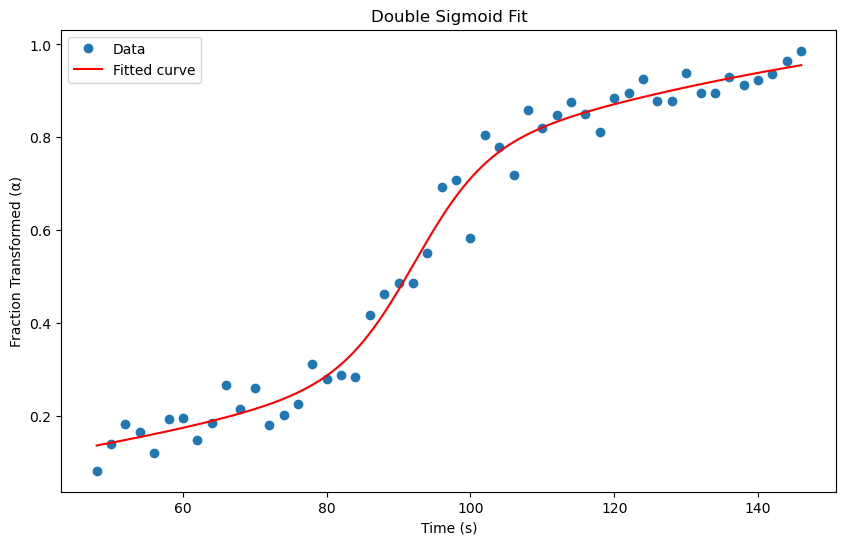

Fitted parameters:
a1 = 0.466504 ± 0.114047
b1 = 0.195195 ± 0.055363
c1 = 92.209321 ± 1.147817
a2 = 0.609453 ± 0.116821
b2 = 0.027022 ± 0.012996
c2 = 94.226726 ± 20.128477


In [27]:
# Load the data
df = pd.read_csv('data/100_MF_pv.csv')

data = df[df['duration_s'] > 45]
data = data[data['duration_s']<150]

# Calculate the fraction transformed starting from the minimum area
min_area = data['pseudovoigt_area'].min()
max_area = data['pseudovoigt_area'].max()
data['alpha'] = (data['pseudovoigt_area'] - min_area) / (max_area - min_area)

# Filter out invalid alpha values (alpha should be between 0 and 1)
valid_data = data[(data['alpha'] > 0) & (data['alpha'] < 1)]

# Define the double sigmoid function
def double_sigmoid(t, a1, b1, c1, a2, b2, c2):
    return a1 / (1 + np.exp(-b1 * (t - c1))) + a2 / (1 + np.exp(-b2 * (t - c2)))

# Perform non-linear curve fitting
initial_guess = [0.5, 0.1, np.median(valid_data['duration_s']), 
                 0.5, 0.1, np.median(valid_data['duration_s'])]
bounds = ([0, 0, valid_data['duration_s'].min(), 0, 0, valid_data['duration_s'].min()],
          [1, 1, valid_data['duration_s'].max(), 1, 1, valid_data['duration_s'].max()])

try:
    popt, pcov = curve_fit(double_sigmoid, valid_data['duration_s'], valid_data['alpha'], 
                           p0=initial_guess, bounds=bounds, maxfev=10000)
    
    # Calculate standard errors
    perr = np.sqrt(np.diag(pcov))
    
    # Generate fitted curve
    t_fit = np.linspace(valid_data['duration_s'].min(), valid_data['duration_s'].max(), 1000)
    alpha_fit = double_sigmoid(t_fit, *popt)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(valid_data['duration_s'], valid_data['alpha'], 'o', label='Data')
    plt.plot(t_fit, alpha_fit, 'r-', label='Fitted curve')
    plt.xlabel('Time (s)')
    plt.ylabel('Fraction Transformed (α)')
    plt.title('Double Sigmoid Fit')
    plt.legend()
    plt.show()
    
    print("Fitted parameters:")
    param_names = ['a1', 'b1', 'c1', 'a2', 'b2', 'c2']
    for name, value, error in zip(param_names, popt, perr):
        print(f"{name} = {value:.6f} ± {error:.6f}")
    
except RuntimeError as e:
    print("Error in curve fitting:", str(e))
    print("Try adjusting the initial guess or bounds, or check your data for anomalies.")


/var/folders/bk/39k5nkd115v_plyymqs2d5bw0000gn/T/ipykernel_95858/1129047165.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['alpha'] = (data['pseudovoigt_area'] - min_area) / (max_area - min_area)


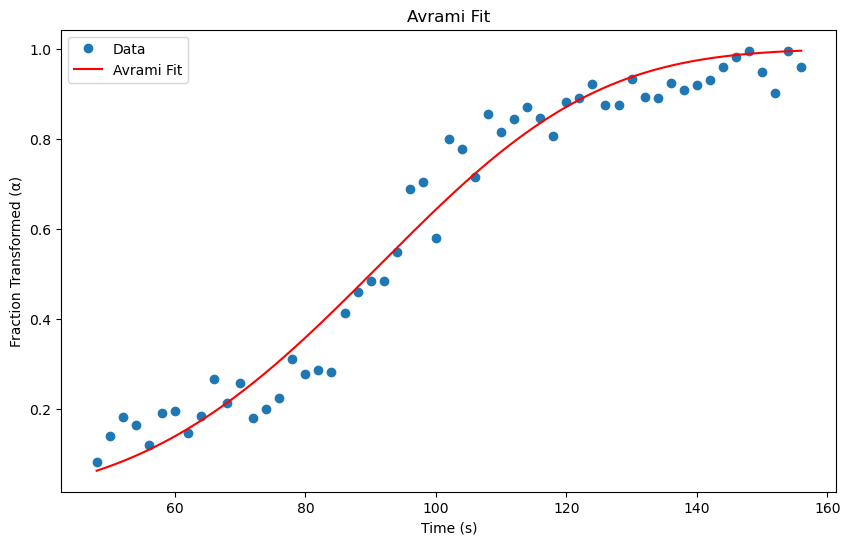

Fitted parameters:
K = 0.000000 ± 0.000000
n = 3.774171 ± 0.038903


In [45]:
# Load the data
df = pd.read_csv('data/100_MF_pv.csv')

# Filter the data for the specified duration range
data = df[(df['duration_s'] > 45) & (df['duration_s'] < 160)]

# Calculate the fraction transformed starting from the minimum area
min_area = data['pseudovoigt_area'].min()
max_area = data['pseudovoigt_area'].max()
data['alpha'] = (data['pseudovoigt_area'] - min_area) / (max_area - min_area)

# Filter out invalid alpha values (alpha should be between 0 and 1)
valid_data = data[(data['alpha'] > 0) & (data['alpha'] < 1)]

# Define the Avrami equation
def avrami_eq(t, K, n):
    return 1 - np.exp(-K * t**n)

# Perform non-linear curve fitting
initial_guess = [0.1, 1.0]  # Initial guess for K and n
bounds = (0, np.inf)  # Boundaries for K and n to be positive

try:
    popt, pcov = curve_fit(avrami_eq, valid_data['duration_s'], valid_data['alpha'], 
                           p0=initial_guess, bounds=bounds, maxfev=10000)
    
    # Calculate standard errors
    perr = np.sqrt(np.diag(pcov))
    
    # Generate fitted curve
    t_fit = np.linspace(valid_data['duration_s'].min(), valid_data['duration_s'].max(), 1000)
    alpha_fit = avrami_eq(t_fit, *popt)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(valid_data['duration_s'], valid_data['alpha'], 'o', label='Data')
    plt.plot(t_fit, alpha_fit, 'r-', label='Avrami Fit')
    plt.xlabel('Time (s)')
    plt.ylabel('Fraction Transformed (α)')
    plt.title('Avrami Fit')
    plt.legend()
    plt.show()
    
    print("Fitted parameters:")
    param_names = ['K', 'n']
    for name, value, error in zip(param_names, popt, perr):
        print(f"{name} = {value:.6f} ± {error:.6f}")

except RuntimeError as e:
    print("Error in curve fitting:", str(e))
    print("Try adjusting the initial guess or bounds, or check your data for anomalies.")



In [47]:
# Find the minimum pseudovoigt_area and the corresponding frame number
min_pseudovoigt_area = df['pseudovoigt_area'].min()
min_frame_number = df.loc[df['pseudovoigt_area'] == min_pseudovoigt_area, 'frame_number'].values[0]

print(f"The minimum pseudovoigt_area is {min_pseudovoigt_area} and the corresponding frame number is {min_frame_number}.")


The minimum pseudovoigt_area is 0.0025427718597612 and the corresponding frame number is 10009.


### starting the alpha at 0

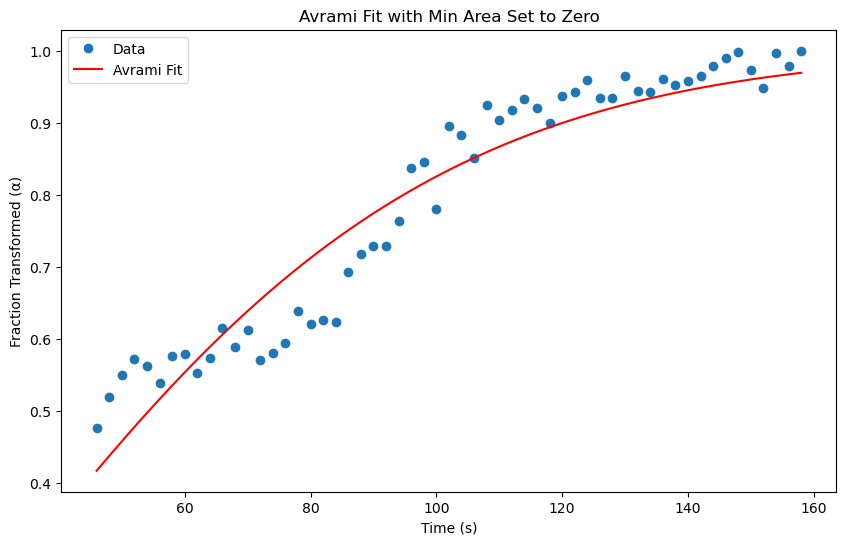

Fitted parameters:
K = 0.001656 ± 0.000567
n = 1.511434 ± 0.077612


In [49]:
# Load the data
df = pd.read_csv('data/100_MF_pv.csv')

# Filter the data for the specified duration range
data = df[(df['duration_s'] > 45) & (df['duration_s'] < 160)].copy()

# Calculate the fraction transformed assuming the minimum area is zero
max_area = data['pseudovoigt_area'].max()
data.loc[:, 'alpha'] = data['pseudovoigt_area'] / max_area

# Filter out invalid alpha values (alpha should be between 0 and 1)
valid_data = data[(data['alpha'] >= 0) & (data['alpha'] <= 1)]

# Define the Avrami equation
def avrami_eq(t, K, n):
    return 1 - np.exp(-K * t**n)

# Perform non-linear curve fitting
initial_guess = [0.1, 1.0]  # Initial guess for K and n
bounds = (0, np.inf)  # Boundaries for K and n to be positive

try:
    popt, pcov = curve_fit(avrami_eq, valid_data['duration_s'], valid_data['alpha'], 
                           p0=initial_guess, bounds=bounds, maxfev=10000)
    
    # Calculate standard errors
    perr = np.sqrt(np.diag(pcov))
    
    # Generate fitted curve
    t_fit = np.linspace(valid_data['duration_s'].min(), valid_data['duration_s'].max(), 1000)
    alpha_fit = avrami_eq(t_fit, *popt)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(valid_data['duration_s'], valid_data['alpha'], 'o', label='Data')
    plt.plot(t_fit, alpha_fit, 'r-', label='Avrami Fit')
    plt.xlabel('Time (s)')
    plt.ylabel('Fraction Transformed (α)')
    plt.title('Avrami Fit with Min Area Set to Zero')
    plt.legend()
    plt.show()
    
    print("Fitted parameters:")
    param_names = ['K', 'n']
    for name, value, error in zip(param_names, popt, perr):
        print(f"{name} = {value:.6f} ± {error:.6f}")

except RuntimeError as e:
    print("Error in curve fitting:", str(e))
    print("Try adjusting the initial guess or bounds, or check your data for anomalies.")
